In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.colors import LogNorm
from scipy.integrate import odeint
sns.set_context("talk", font_scale=1.4)


# for using LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Infer Markov Chain transition matrix from political regime time-series data

In [2]:
# load the Polity5 data from the excel data frame
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')

In [3]:
nCountries = len(timeSeries['country'].unique()) # numer of countries

In [4]:
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity2'])

In [5]:
# functions to calculating the transition probabilities

def estimateTransitionMatrix(data,approach='frequentist'):
    
    # construct some output matrices
    countMatrix=np.zeros((21,21)) # empty transition matrix
    
    # split the timeseries into one for each country 
    uniqueCountries = data['country'].unique()
    countryTimeseries =[]
    
    # count for each country the transitions
    for country in uniqueCountries:
        sortedPolity2Country = data[data['country'] == country].sort_values(by='year')["polity2"].tolist()
        T=len(sortedPolity2Country)# number of data points
        for t in range(T-1): # go over all years
            fromTransition = int(sortedPolity2Country[t] + 10)
            toTransition = int(sortedPolity2Country[t+1] + 10)
            
            if  (fromTransition>=0) and ((toTransition>=0)):
                
                # increase the count for this year
                countMatrix[fromTransition,toTransition] = countMatrix[fromTransition,toTransition] + 1
    
    if approach=='frequentist':
        # compute the transition probabilities as count over total outgoing
        P = countMatrix/countMatrix.sum(axis=1)[:,None]
    if approach=='bayesian':
        # we use a Dirichlet prior for each row
        priorMatrix = np.zeros((21,21)) + 1/21
        combinedMatrix = countMatrix + priorMatrix
        # this is the posterior mean
        P = combinedMatrix/combinedMatrix.sum(axis=1)[:,None]
    
    return(P)

def computeSteadyStateBruteForce(transitionMatrix,nSteps,initialCondition=0):
    # computes it the brutal way with iterating the transition
    
    n=transitionMatrix.shape[0] # number of Markov states
    
    if initialCondition==0:
        # if it is zero use a random vector
        x = np.random.rand(n)
        x = x / np.sum(x)
    else:
        # set it to the intial condition that we provided
        x= initialCondition
    # fo over each step
    for i in np.arange(nSteps):
        #x= P_allCountries.dot(x)
        x= x.dot(transitionMatrix)
    
    return(x)

def computeSteadyStateEV(transitionMatrix):
    # compute it as eigenvector
    valsT, vecsT = np.linalg.eig(transitionMatrix.transpose())
    
    # find the index of the eigenvalue closest to 1
    index_ev1 = (np.abs(valsT - 1)).argmin()
    
    v = vecsT[:,index_ev1]
    return((v/np.sum(v)).real) # normalise it for the return and also ignore the imaginary part (from numerical approx.)


def simulateMarkovChain(transitionMatrix,initialCondition,nSteps=100):
    
    n=transitionMatrix.shape[0] # number of states
    
    stateVector=[initialCondition]
    for i in np.arange(nSteps):
        newstate = np.random.choice(np.arange(n), p=transitionMatrix[stateVector[i],:])
        stateVector.append(newstate)
    return(stateVector)
    

def computeHittingTime(transitionMatrix,initialCondition,hittingTarget,rel):
    
    n=transitionMatrix.shape[0] # number of states
    
    hittingTimes = np.zeros(rel)
    
    # go over realisations
    for r in np.arange(rel):
        t=0
        oldstate = initialCondition # we start at the initial condition
        while ((oldstate in hittingTarget) == False):
            t=t+1
            newstate = np.random.choice(np.arange(n), p=transitionMatrix[oldstate,:])
            oldstate = newstate
        # save the number of steps needed
        hittingTimes[r] = t
    return(hittingTimes)  


def createSimpleMarkovChain():
    
    P=np.zeros((2,2)) # empty transition matrix
    
    P[0,0] = 0.9
    P[0,1] = 0.1
    P[1,0] = 0.5
    P[1,1] = 0.5
    
    return(P)

### Estimate the end of history for each country

In [66]:
uniqueCountries = timeSeries['country'].unique()

EoH_list = []

EoH_mean = []

nTimePoints = []
maxYear = []
fullDemocracy = []


EoH =np.zeros(shape=(len(uniqueCountries),21))

i=0
for u in uniqueCountries:
    timeSeries_Country = timeSeries[timeSeries['country'] == u]

    P_allCountries_Country = estimateTransitionMatrix(timeSeries_Country,approach='bayesian')
    steadyStateEV_country = computeSteadyStateEV(P_allCountries_Country)
    

    EoH_list.append(steadyStateEV_country)
    EoH_mean.append(np.sum(steadyStateEV_country*np.arange(-10,11,1)))
    nTimePoints.append(timeSeries_Country.shape[0])
    maxYear.append(timeSeries_Country['year'].max())
    fullDemocracy.append(steadyStateEV_country[-1])

    EoH[i,:] = steadyStateEV_country
    i=i+1

countryOut = pd.DataFrame()
countryOut['country'] = uniqueCountries
countryOut['mean s'] = EoH_mean
countryOut['length time series'] = nTimePoints
countryOut['last year'] = maxYear
countryOut['full democracy'] = fullDemocracy

In [97]:
countryOut_new = pd.concat([countryOut, pd.DataFrame(100*EoH,columns = np.arange(-10,11,1))], axis=1)


In [98]:
selectedData = countryOut_new[countryOut_new['length time series'] > 150].sort_values(by='mean s',ascending=False)

In [99]:
selectedData

,country,mean s,length time series,last year,full democracy,-10,-9,-8,-7,-6,...,1,2,3,4,5,6,7,8,9,10
163,Switzerland,8.900524,171,2018,0.895288,0.523560,0.523560,0.523560,0.523560,0.523560,...,0.523560,0.523560,0.523560,0.523560,0.523560,0.523560,0.523560,0.523560,0.523560,89.528796
116,New Zealand,8.725275,162,2018,0.796703,0.549451,0.549451,0.549451,0.549451,0.549451,...,0.549451,0.549451,0.549451,1.098901,0.549451,0.549451,0.549451,0.549451,9.340659,79.670330
181,United States,8.712825,219,2018,0.637293,0.373721,0.373721,0.373721,0.373721,0.373721,...,0.373721,0.373721,0.373721,1.868607,0.373721,0.373721,0.373721,14.339103,13.709677,63.729347
25,Canada,8.696903,152,2018,0.758850,0.442478,0.442478,0.442478,0.442478,0.442478,...,0.442478,0.442478,0.442478,4.867257,0.442478,0.442478,0.442478,0.442478,11.283186,75.884956
177,United Kingdom,6.859351,219,2018,0.494875,0.403294,0.403294,0.403294,0.403294,0.403294,...,0.403294,0.403294,13.308688,0.403294,0.403294,0.403294,7.763401,15.325155,0.403294,49.487481
120,Norway,6.648932,200,2018,0.758831,0.348888,0.348888,0.348888,10.466638,0.348888,...,0.348888,0.348888,0.348888,0.348888,0.348888,0.348888,0.348888,0.348888,0.348888,75.883123
36,Costa Rica,6.606829,181,2018,0.553873,0.424424,0.424424,0.424424,0.424424,0.424424,...,1.909906,0.424424,0.424424,0.810263,12.732710,0.424424,0.424424,9.723160,2.073888,55.387287
12,Belgium,6.010296,184,2018,0.220077,0.514801,0.514801,0.514801,0.514801,0.514801,...,0.514801,0.514801,0.514801,23.938224,0.514801,14.414414,0.514801,14.671815,12.870013,22.007722
121,Netherlands,5.503189,199,2018,0.649554,0.340136,0.340136,0.340136,2.295918,4.421769,...,0.340136,0.340136,0.340136,0.340136,0.340136,0.340136,0.340136,0.340136,0.340136,64.955357
42,Denmark,5.468909,214,2018,0.640944,5.666810,3.885812,0.323818,0.323818,0.323818,...,0.642576,5.623803,0.929711,0.950582,0.640678,0.644157,0.645896,0.646766,0.647201,64.094381


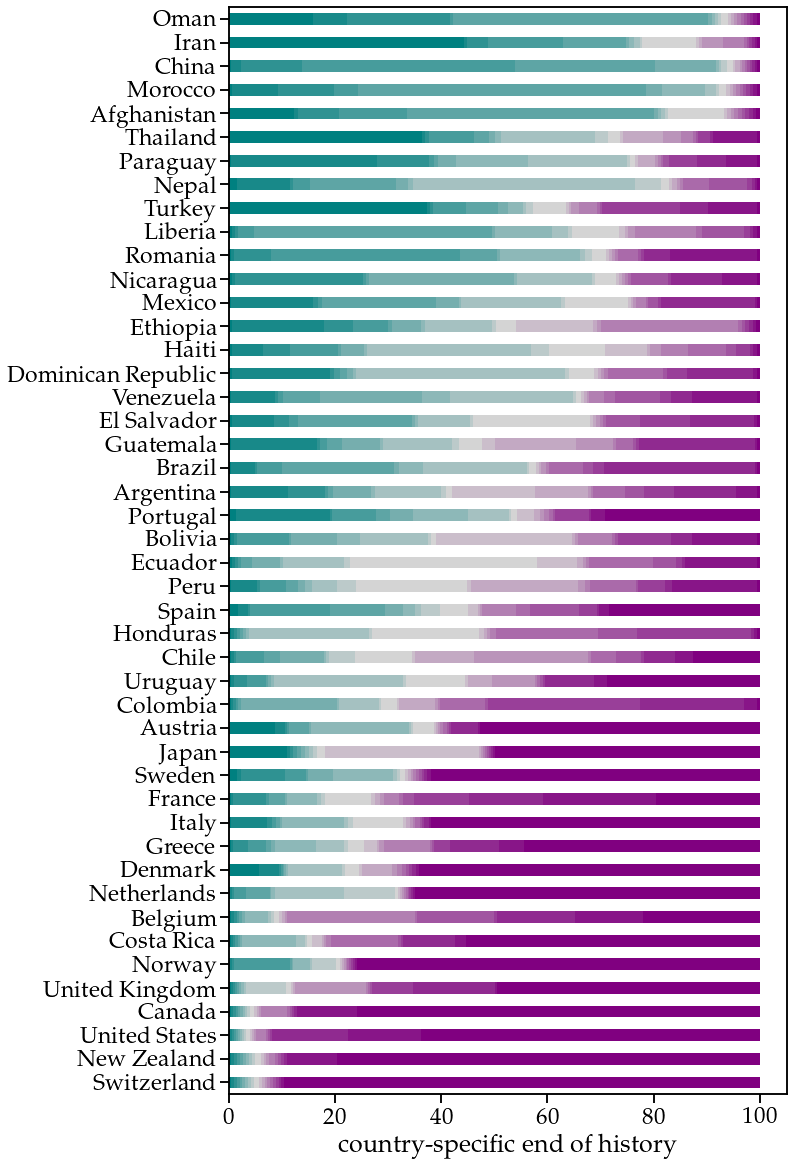

In [121]:
teal = [0,0.5,0.5]
lightgray = [0.83,0.83,0.83]
purple = [0.5,0.0,0.5]

clrs = [teal,lightgray,purple]
clrs1 = np.linspace(teal, lightgray, 10, axis=1)
clrs2 = np.linspace(lightgray, purple, 11, axis=1)

clrs = np.concatenate((clrs1,clrs2), axis=1)

clrsL = np.transpose(clrs).tolist()


plt.rcParams["figure.figsize"] = (10, 20)

ax = selectedData[np.arange(-10,11,1).tolist() + ['country']].plot.barh(stacked=True, color=clrsL,x='country',legend=None)
plt.ylabel('')
plt.xlabel('country-specific end of history')


plt.savefig('./fig/countrySpecificEoH.pdf',bbox_inches='tight')

#selectedData[np.arange(-10,11,1).tolist() + ['country']].plot(kind='barh', stacked=True, color=clrsL,legend=None)


#selectedData[np.arange(-10,11,1).tolist() + ['country']].plot(kind='bar', stacked=True, color=clrsL,x='country',legend=None)
#ax.get_legend().remove()




In [89]:
np.arange(-10,11,1).tolist() + ['country']

[-10,
 -9,
 -8,
 -7,
 -6,
 -5,
 -4,
 -3,
 -2,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 'country']

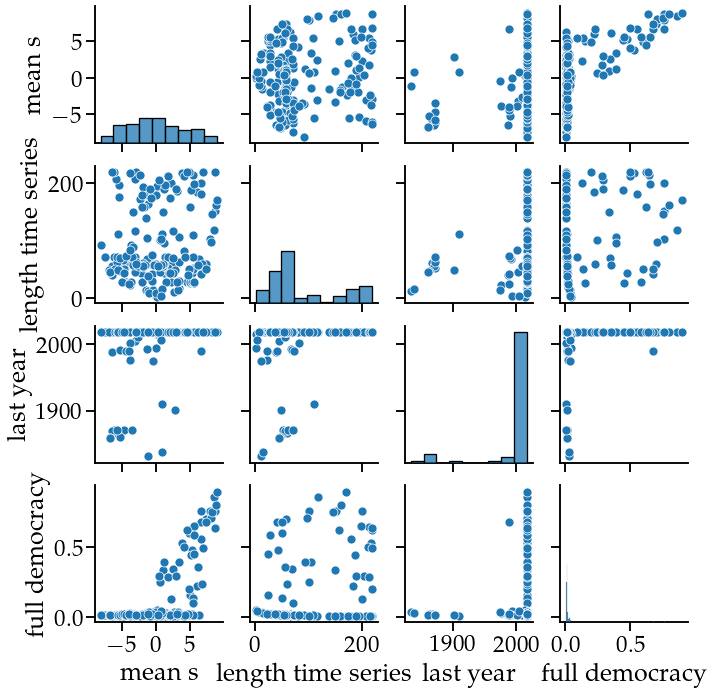

In [41]:
sns.pairplot(data=countryOut)

<AxesSubplot:xlabel='length time series', ylabel='mean s'>

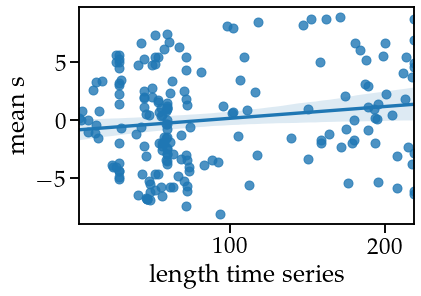

In [32]:
#plt.scatter(countryOut['length time series'],countryOut['mean s'])
sns.regplot(data=countryOut,x='length time series',y=countryOut['mean s'])

Text(0, 0.5, 'Probability full democracy $P(s=10)$ at country-specific EoH')

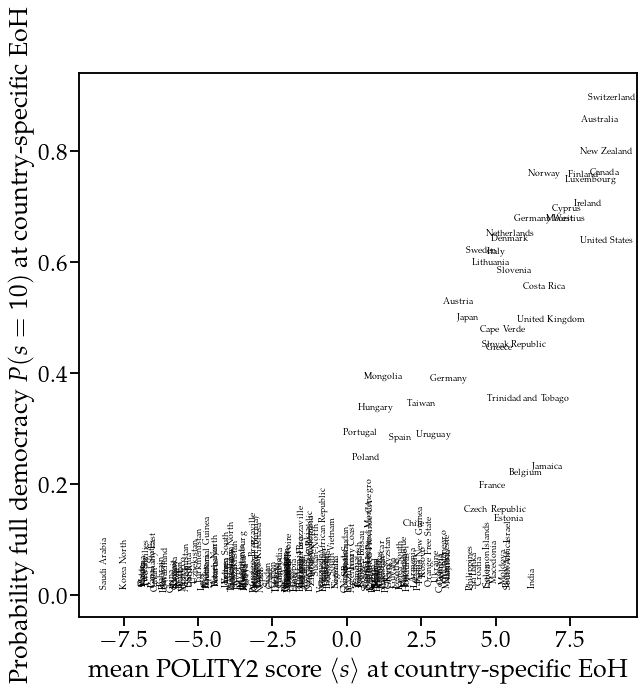

In [63]:
plt.figure(figsize=(10,10))
plt.scatter(countryOut['mean s'],countryOut['full democracy'],color='w')

for index, row in countryOut.iterrows():
    if row['full democracy']<0.1:
        plt.text(row['mean s'],row['full democracy'],s=row['country'],ha='center',va='bottom',size=9,rotation=90)
    else:
        plt.text(row['mean s'],row['full democracy'],s=row['country'],ha='center',va='center',size=9)

    #print(row['c1'], row['c2'])

plt.xlabel(r'mean POLITY2 score $\langle s \rangle$ at country-specific EoH')
plt.ylabel(r'Probability full democracy $P(s=10)$ at country-specific EoH')

In [43]:
selectedData = countryOut[countryOut['length time series'] > 150].sort_values(by='mean s',ascending=False)

Text(0, 0.5, 'Probability full democracy $P(s=10)$ at country-specific EoH')

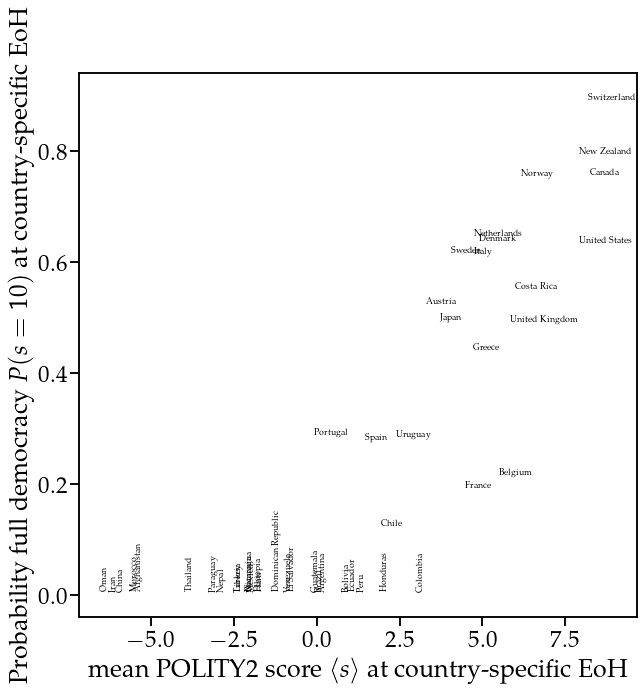

In [62]:
plt.figure(figsize=(10,10))
plt.scatter(selectedData['mean s'],selectedData['full democracy'],color='w')

for index, row in selectedData.iterrows():
    if row['full democracy']<0.1:
        plt.text(row['mean s'],row['full democracy'],s=row['country'],ha='center',va='bottom',size=9,rotation=90)
    else:
        plt.text(row['mean s'],row['full democracy'],s=row['country'],ha='center',va='center',size=9)

    #print(row['c1'], row['c2'])

plt.xlabel(r'mean POLITY2 score $\langle s \rangle$ at country-specific EoH')
plt.ylabel(r'Probability full democracy $P(s=10)$ at country-specific EoH')

<Figure size 720x720 with 0 Axes>

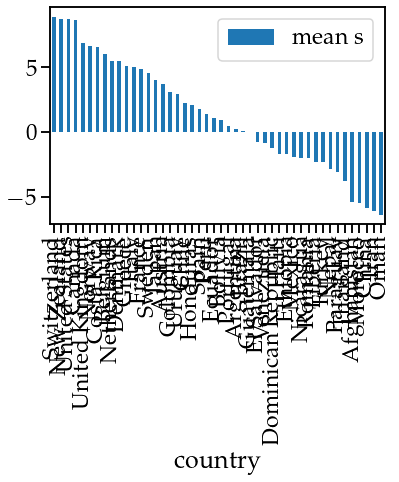

In [47]:
plt.figure(figsize=(10,10))
ax = selectedData.plot(kind='bar',y='mean s',x='country') 

In [40]:
countryOut[countryOut['length time series'] == 219].sort_values(by='mean s',ascending=False)

,country,mean s,length time series,last year,full democracy
181,United States,8.712825,219,2018,0.637293
177,United Kingdom,6.859351,219,2018,0.494875
55,France,4.877951,219,2018,0.195236
162,Sweden,4.527293,219,2018,0.619823
115,Nepal,-2.871643,219,2018,0.005033
76,Iran,-6.119900,219,2018,0.004996
123,Oman,-6.396355,219,2018,0.006074


In [35]:
countryOut.sort_values(by='length time series',ascending=False)

,country,mean s,length time series,last year,full democracy
181,United States,8.712825e+00,219,2018,0.637293
123,Oman,-6.396355e+00,219,2018,0.006074
115,Nepal,-2.871643e+00,219,2018,0.005033
76,Iran,-6.119900e+00,219,2018,0.004996
162,Sweden,4.527293e+00,219,2018,0.619823
...,...,...,...,...,...
146,Sudan-North,-1.000000e+00,8,2018,0.035714
158,South Sudan,-2.664535e-15,8,2018,0.035714
190,Serbia and Montenegro,7.500000e-01,4,2006,0.041667
19,Bosnia,7.216450e-16,3,1994,0.043478


In [26]:
import scipy.stats as stats

stats.pearsonr(countryOut['mean s'],countryOut['last year'])

(0.31425845035843947, 7.67555242373298e-06)

In [47]:

# timeSeriesTime1800= timeSeries[timeSeries['year']>=1800]
# P_allCountries_Time1800 = estimateTransitionMatrix(timeSeriesTime1800,approach='bayesian')
# steadyStateEV_Time1800 = computeSteadyStateEV(P_allCountries_Time1800)

# timeSeriesTime1850= timeSeries[timeSeries['year']>=1850]
# P_allCountries_Time1850 = estimateTransitionMatrix(timeSeriesTime1850,approach='bayesian')
# steadyStateEV_Time1850 = computeSteadyStateEV(P_allCountries_Time1850)

# timeSeriesTime1900= timeSeries[timeSeries['year']>=1900]
# P_allCountries_Time1900 = estimateTransitionMatrix(timeSeriesTime1900,approach='bayesian')
# steadyStateEV_Time1900 = computeSteadyStateEV(P_allCountries_Time1900)

# timeSeriesTime1950= timeSeries[timeSeries['year']>=1950]
# P_allCountries_Time1950 = estimateTransitionMatrix(timeSeriesTime1950,approach='bayesian')
# steadyStateEV_Time1950 = computeSteadyStateEV(P_allCountries_Time1950)


### Plot end of history

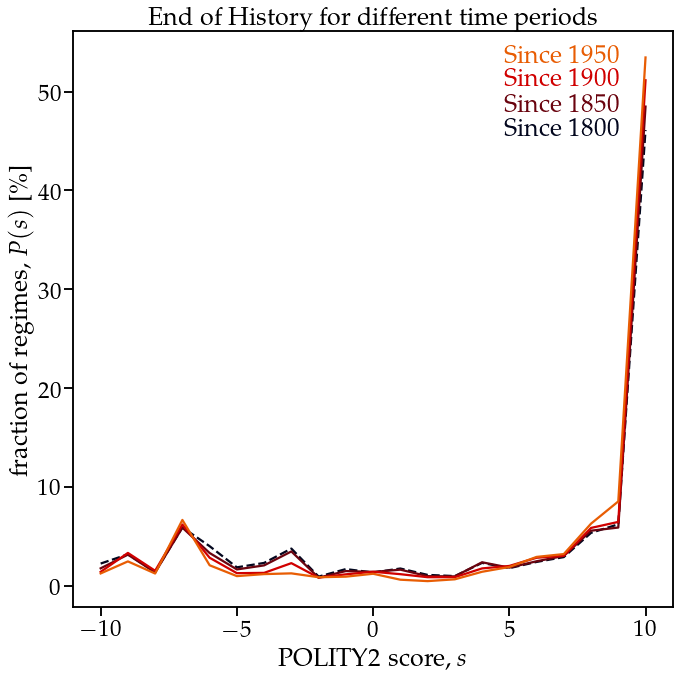

In [45]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(-10,11,1),100*steadyStateEV_Time1800,label='Since 1800', linestyle='dashed',color='#03071e')
plt.plot(np.arange(-10,11,1),100*steadyStateEV_Time1850,label='Since 1850', linestyle='solid',color='#6a040f')
plt.plot(np.arange(-10,11,1),100*steadyStateEV_Time1900,label='Since 1900', linestyle='solid',color='#d00000')
plt.plot(np.arange(-10,11,1),100*steadyStateEV_Time1950,label='Since 1950', linestyle='solid',color='#e85d04')

#plt.legend(loc=0)


plt.text(9,100*steadyStateEV_Time1800[-1],'Since 1800',ha='right',va='center',color='#03071e')
plt.text(9,100*steadyStateEV_Time1850[-1],'Since 1850',ha='right',va='center',color='#6a040f')
plt.text(9,100*steadyStateEV_Time1900[-1],'Since 1900',ha='right',va='center',color='#d00000')
plt.text(9,100*steadyStateEV_Time1950[-1],'Since 1950',ha='right',va='center',color='#e85d04')


plt.title('End of History for different time periods')
plt.xlabel(r'POLITY2 score, $s$')
plt.ylabel(r'fraction of regimes, $P(s)$ [$\%$]')
plt.tight_layout()
plt.savefig('./fig/FigSI-EoH_time.pdf',bbox_inches='tight')

In [60]:
steadyStateEV_Time1950[-1]

0.5344757021491315

### Plot transition matrix

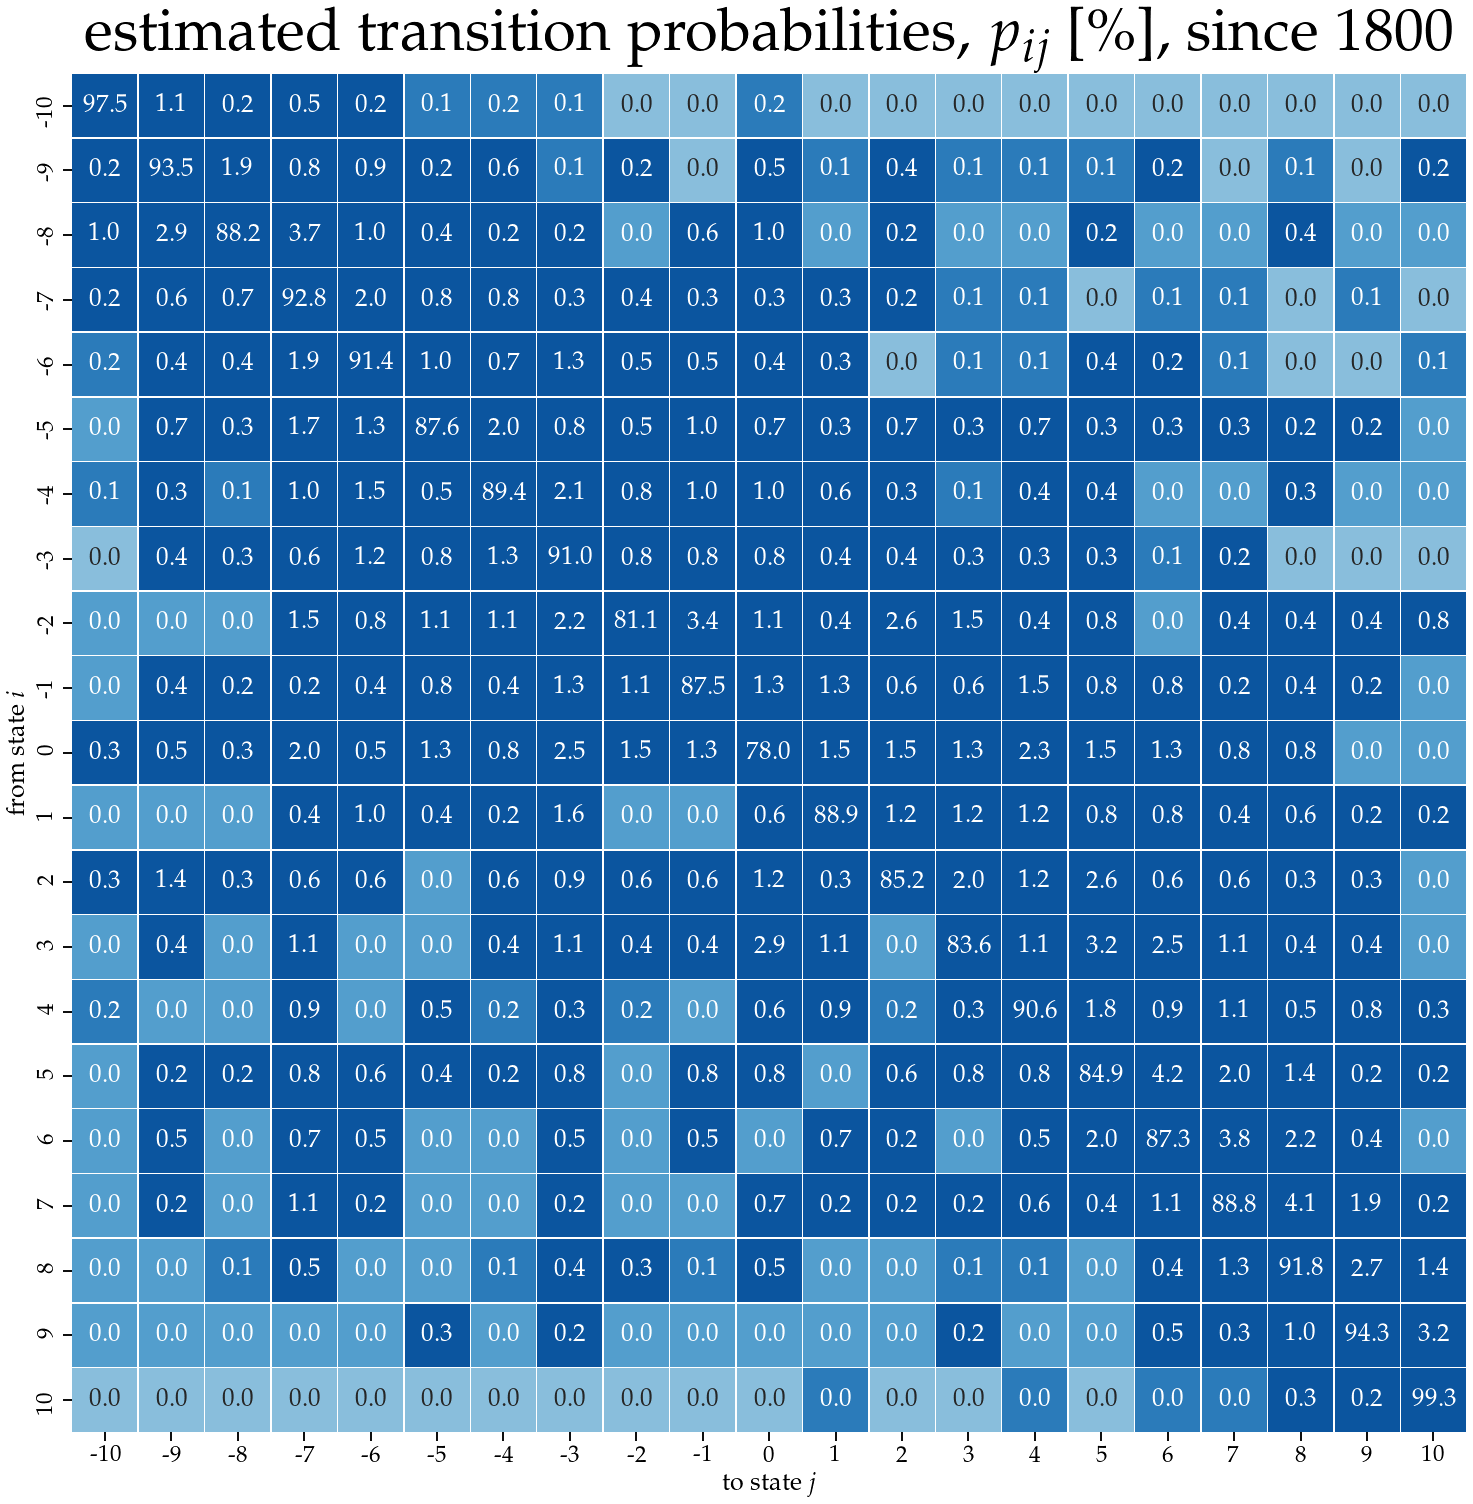

In [53]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_Time1800*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_Time1800.min(), vmax=P_allCountries_Time1800.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$], since 1800',size=60)
plt.savefig('./fig/estimatedTransitionProbabilities1800.pdf',bbox_inches='tight')

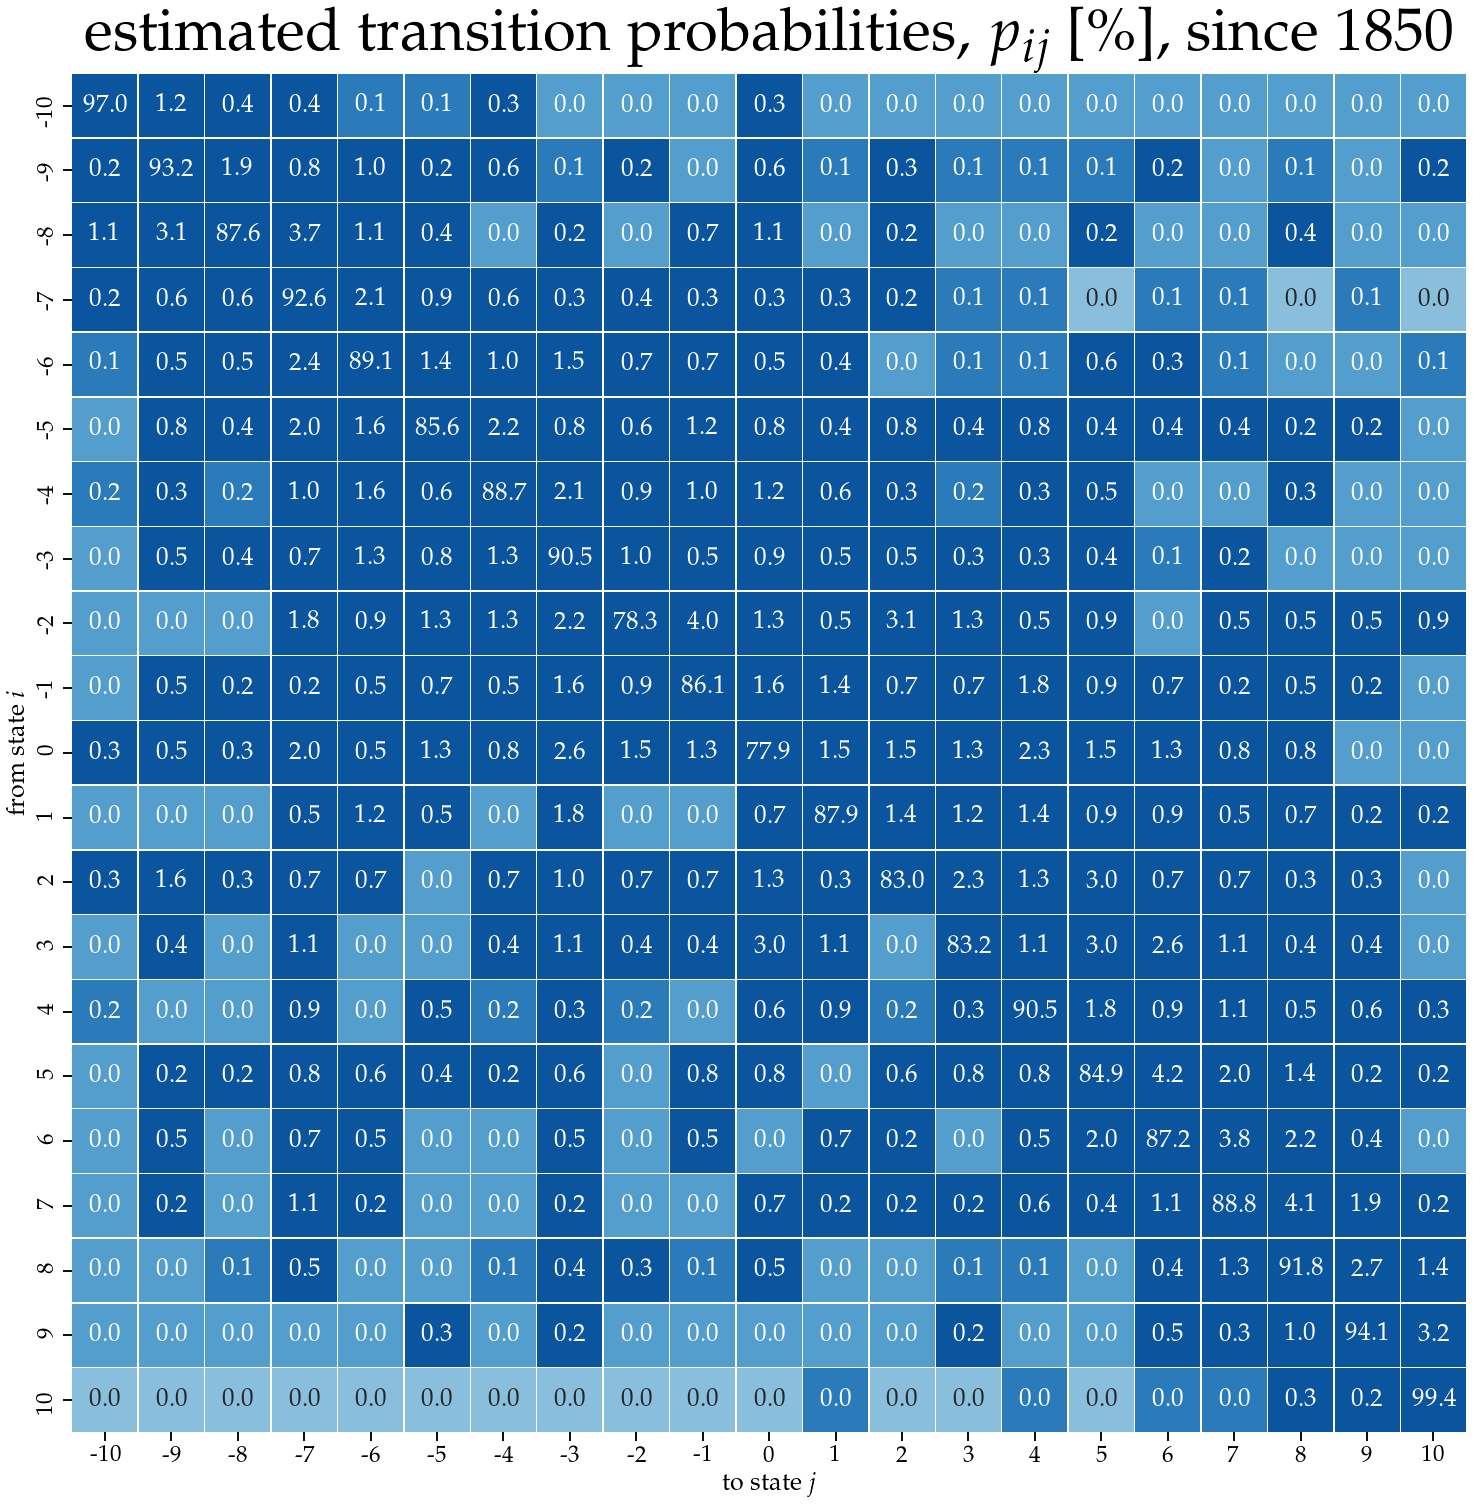

In [54]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_Time1850*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_Time1800.min(), vmax=P_allCountries_Time1800.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$], since 1850',size=60)
plt.savefig('./fig/estimatedTransitionProbabilities1850.pdf',bbox_inches='tight')

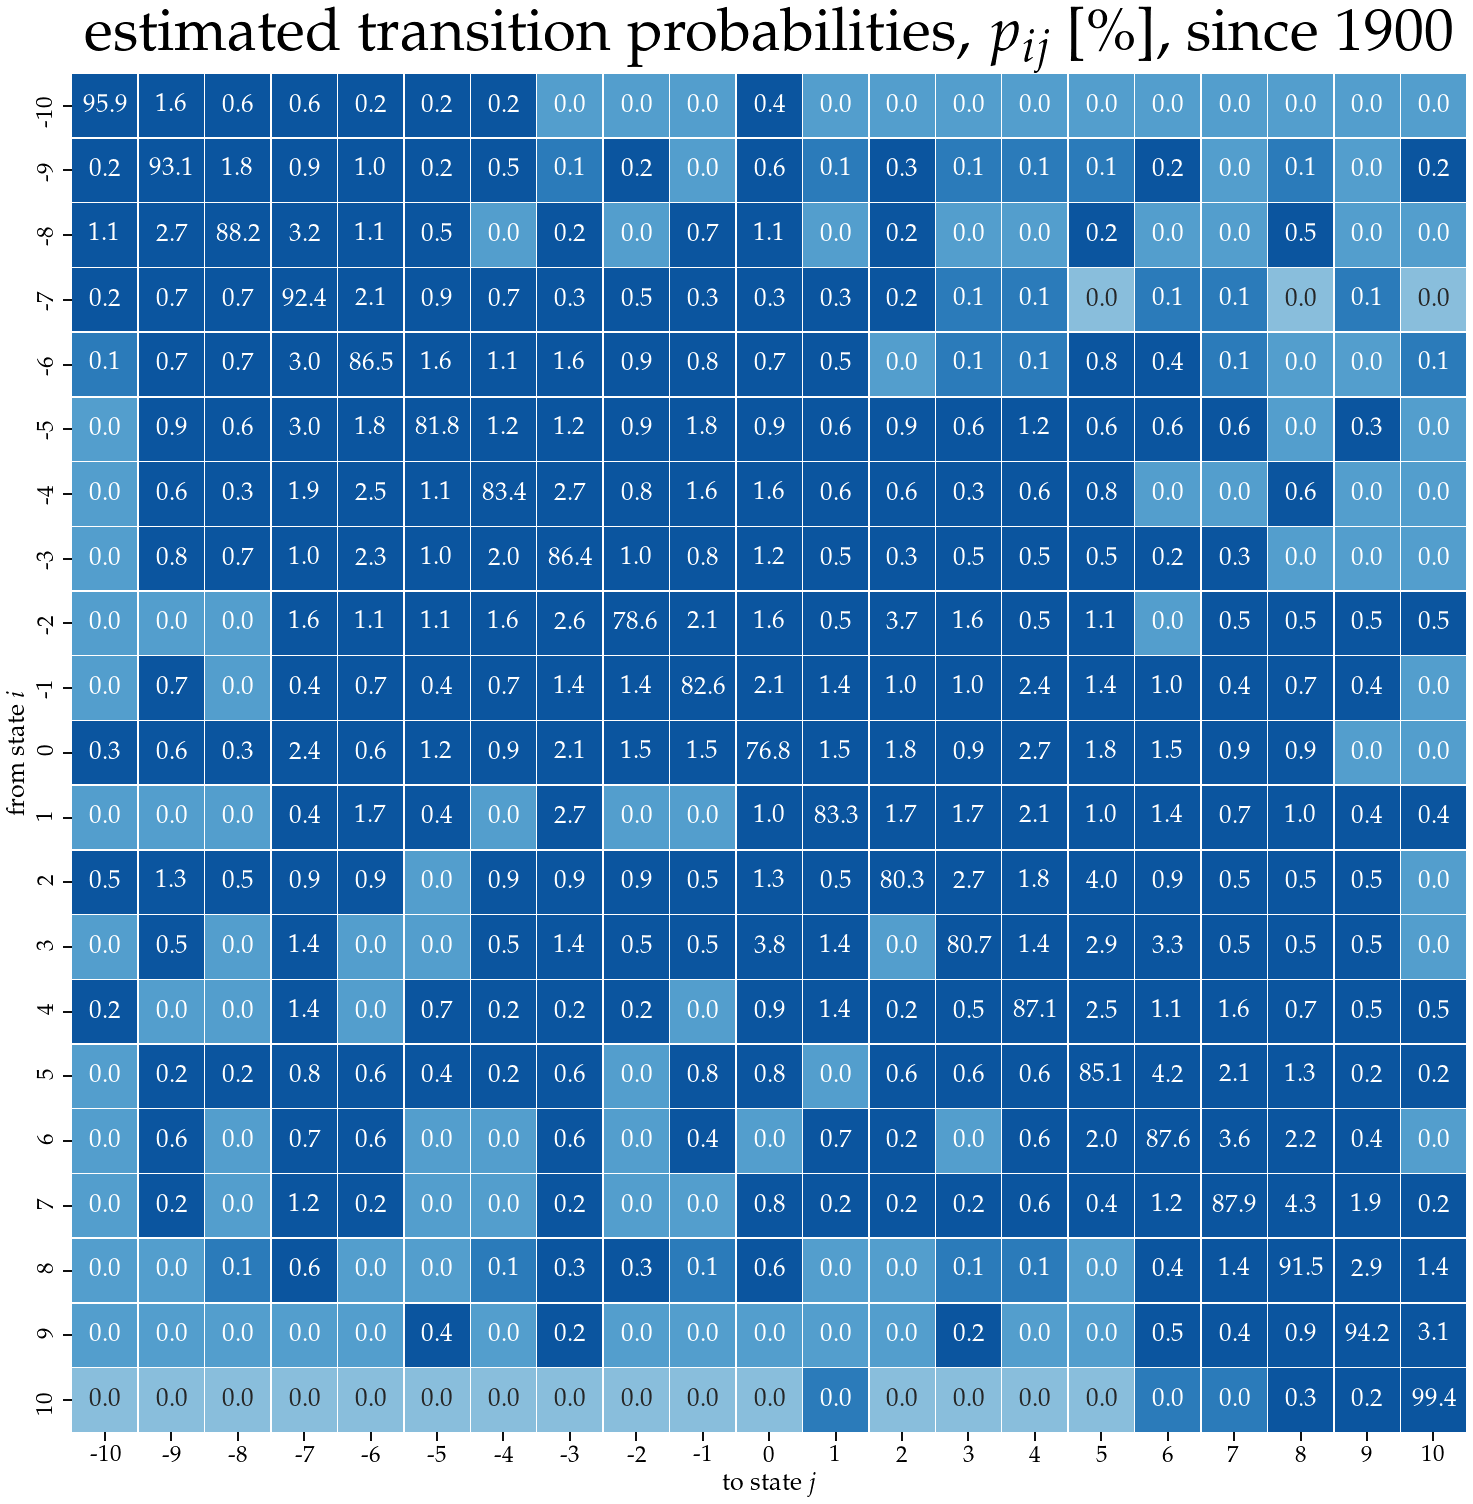

In [55]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_Time1900*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_Time1800.min(), vmax=P_allCountries_Time1800.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$], since 1900',size=60)
plt.savefig('./fig/estimatedTransitionProbabilities1900.pdf',bbox_inches='tight')

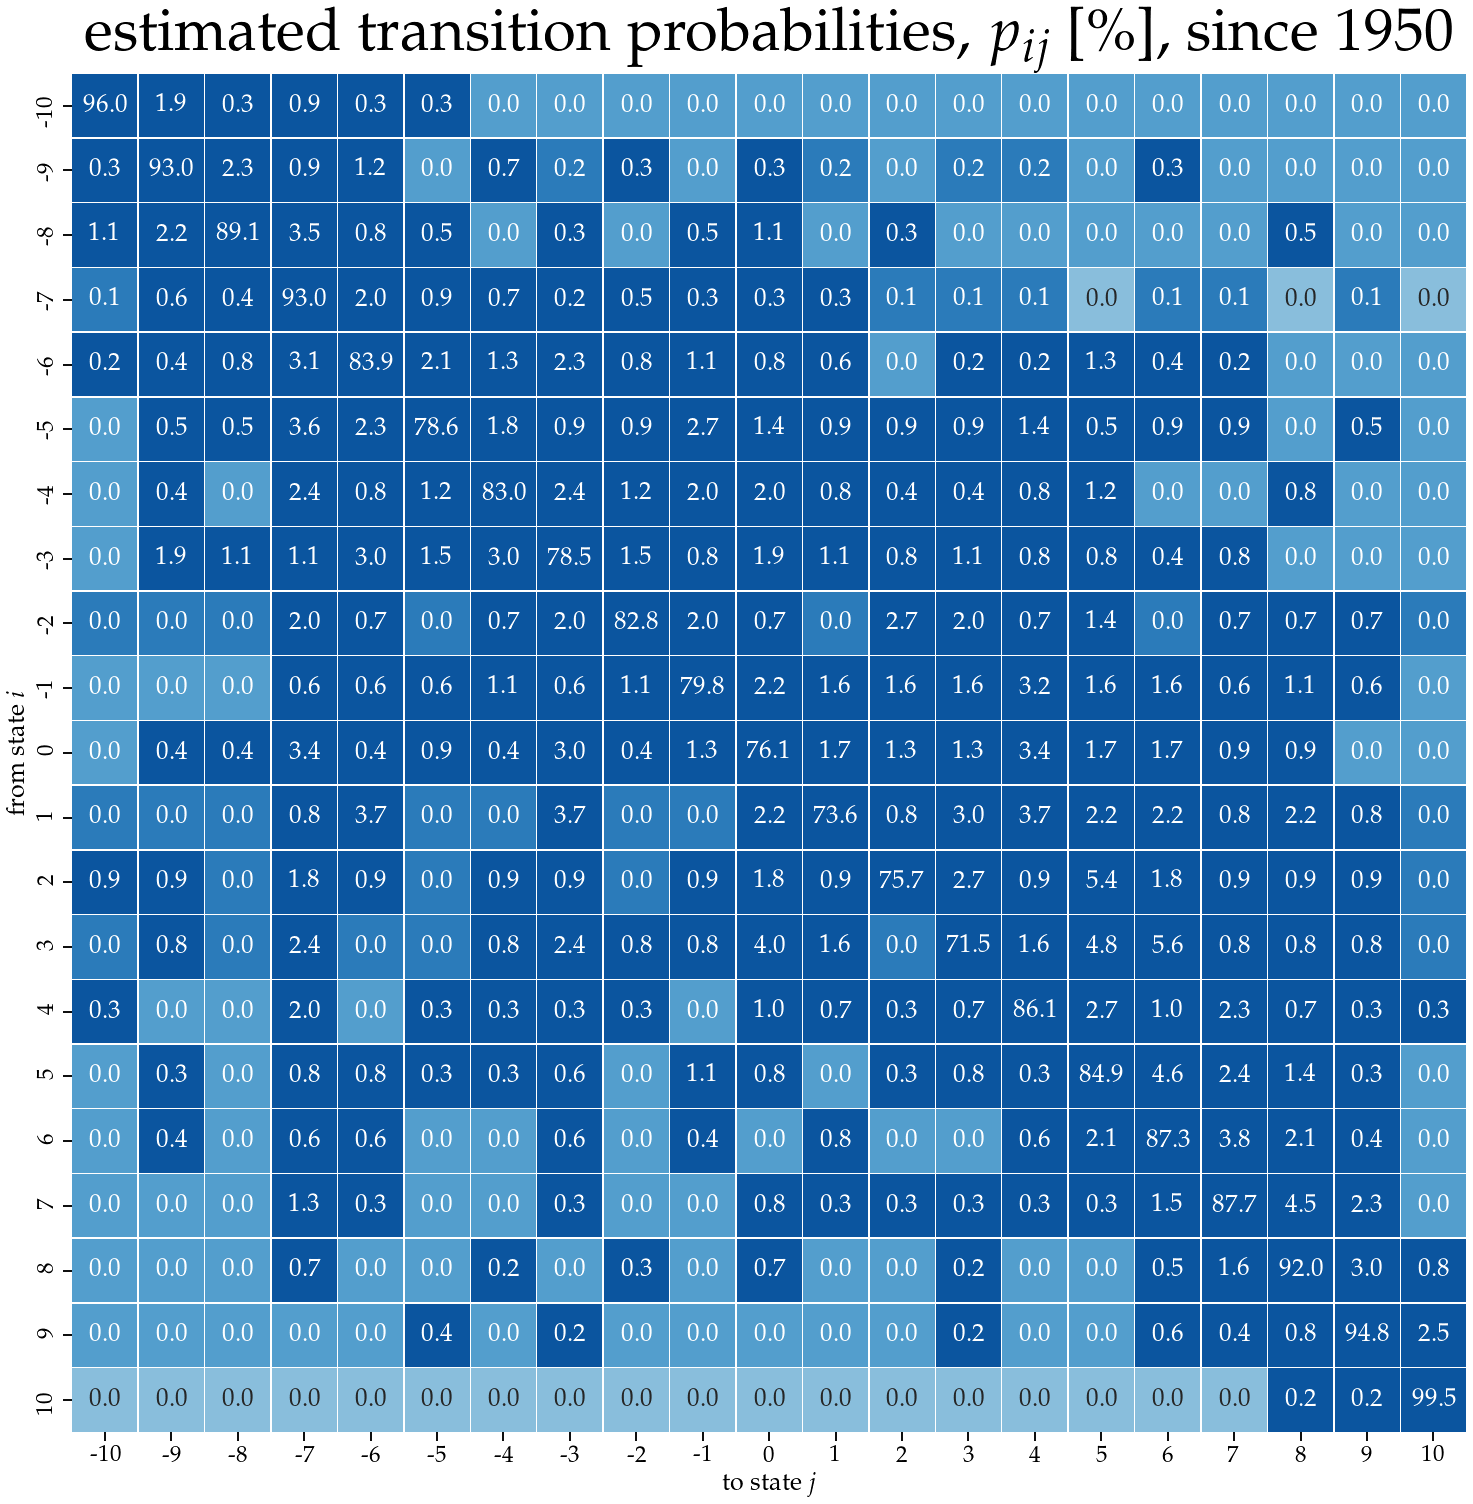

In [56]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_Time1950*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_Time1800.min(), vmax=P_allCountries_Time1800.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$], since 1950',size=60)
plt.savefig('./fig/estimatedTransitionProbabilities1950.pdf',bbox_inches='tight')